## Preliminares

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler

from qiskit import Aer, QuantumCircuit, transpile
from qiskit.opflow import Z, I, StateFn, Gradient, PauliExpectation
from qiskit.utils import  algorithm_globals, QuantumInstance
from qiskit.algorithms.optimizers import SPSA

from qiskit_machine_learning.neural_networks import OpflowQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_state_qsphere

from IPython.display import clear_output

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.decomposition import PCA

algorithm_globals.random_seed = 42



from Aux_Data import plot_predicted, plot_area, plot_bloch_sphere, plot_sampled_features, get_binary_dataset
from QWNN import  quantum_weightless_neuron_ry, quantum_weightless_nn
from quantum_encoding import angle_encoding
from Aux_QuantumML import  ttn



Experimentos com uma Rede no dataset Wine

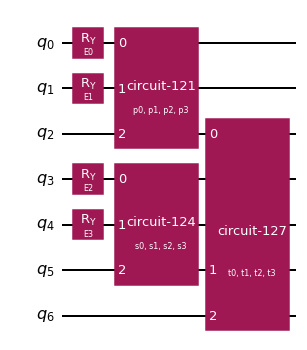

In [5]:
hamiltonian_qwnn = Z ^ I ^ I ^ I ^ I ^ I ^ I
qwnn_qc = QuantumCircuit(7)
feature_map = angle_encoding(4)
qwnn_qc.append(feature_map, [0,1,3,4])
ansatz_qwnn= quantum_weightless_nn()
qwnn_qc.append(ansatz_qwnn, [0,1,2,3,4,5,6])
qwnn_qc.decompose().draw('mpl', style='iqx')

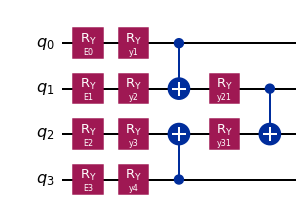

In [6]:
hamiltonian_ttn = I ^ Z ^ I ^ I 
ttn_qc = QuantumCircuit(4)
ttn_qc.append(feature_map, [0,1,2,3])
ansatz_ttn= ttn()
ttn_qc.append(ansatz_ttn, [0,1,2,3])
ttn_qc.decompose().draw('mpl', style='iqx')

In [7]:

def get_opflow_qnn(quantum_circuit, feature_map, ansatz, hamiltonian, seed=42):
    algorithm_globals.random_seed = 42
    simulator = Aer.get_backend("aer_simulator", device="GPU", max_parallel_threads =0, max_parallel_experiments =0)
    simulator.set_options(device='GPU')
    quantum_instance = QuantumInstance(simulator, shots=1024, seed_simulator=algorithm_globals.random_seed, seed_transpiler=algorithm_globals.random_seed)
    qnn_expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(quantum_circuit)
    qnn = OpflowQNN(qnn_expectation, 
                    input_params=list(feature_map.parameters), 
                    weight_params=list(ansatz.parameters),
                    exp_val=PauliExpectation(),
                    gradient=Gradient(),  
                    quantum_instance=quantum_instance)
    return qnn


In [8]:
# callback function that draws a live plot when the .fit() method is called
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.figsize"] = (6, 4)
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    
def run_experiments(X, y, n_times, ansatz_chosen= "QWNN", apply_pca = False, pca_components = 4):
    if(ansatz_chosen=="QWNN"):
        quantum_circuit = qwnn_qc
        ansatz = ansatz_qwnn
        hamiltonian = hamiltonian_qwnn
    if(ansatz_chosen=="TTN"):
        quantum_circuit = ttn_qc
        ansatz = ansatz_ttn
        hamiltonian = hamiltonian_ttn
    normalization = np.pi
    score_list = []
    if(apply_pca): pca = PCA(pca_components)
    for i in range(n_times):
        print("iteracao :", i)
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=algorithm_globals.random_seed, stratify=y)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)
        if(apply_pca):
            X_train_new = pca.fit_transform(X_train)
            X_test_new = pca.transform(X_test)
        else:
            X_train_new, X_test_new = X_train, X_test
        minmax_scale = MinMaxScaler((0, normalization)).fit(X_train_new)
        X_train_new = minmax_scale.transform(X_train_new)
        X_test_new = minmax_scale.transform(X_test_new)
        qnn = get_opflow_qnn(quantum_circuit, feature_map, ansatz, hamiltonian)
        clf = NeuralNetworkClassifier(qnn, optimizer = SPSA())
        clf.fit(X_train_new, y_train)
        score = clf.score(X_test_new, y_test)
        score_list.append(score)
        print("score: ", score)
    print("Mean: ", np.mean(score_list))
    print("Std: ", np.std(score_list))
    print(score_list)
    return score_list

## Base de dados selecionada:

In [9]:
class_a = 0
class_b = 1
# Loading some example data
wine = datasets.load_wine()
X_all = wine.data[:, :]
Y_all = wine.target
X, y = get_binary_dataset(X_all, Y_all, class_a, class_b)


In [6]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)

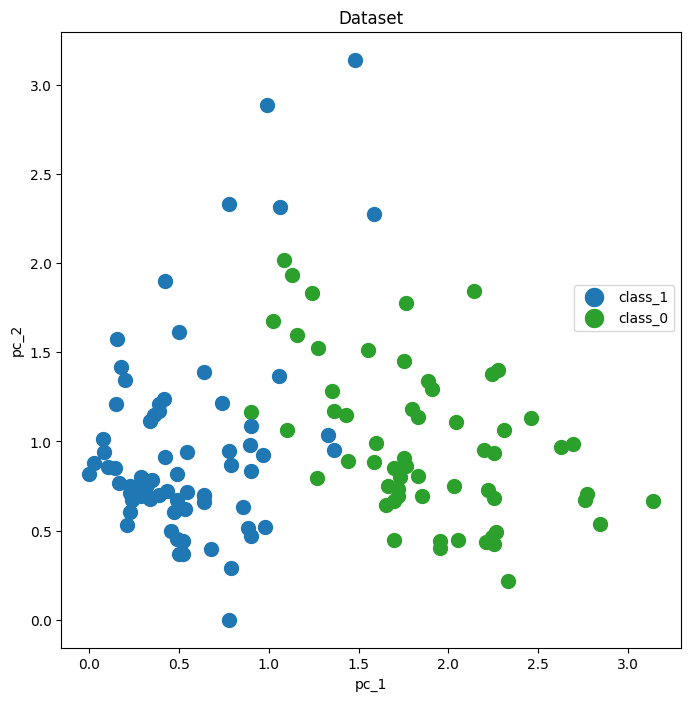

In [9]:
normalization = np.pi
minmax_scale = MinMaxScaler((0, normalization)).fit(X_pca)
X_pca = minmax_scale.transform(X_pca)
plot_sampled_features(X_pca[:, [0,1]], y, axis_x_name='pc_1', axis_y_name='pc_2', class_name_minus="class_0", class_name_plus="class_1")

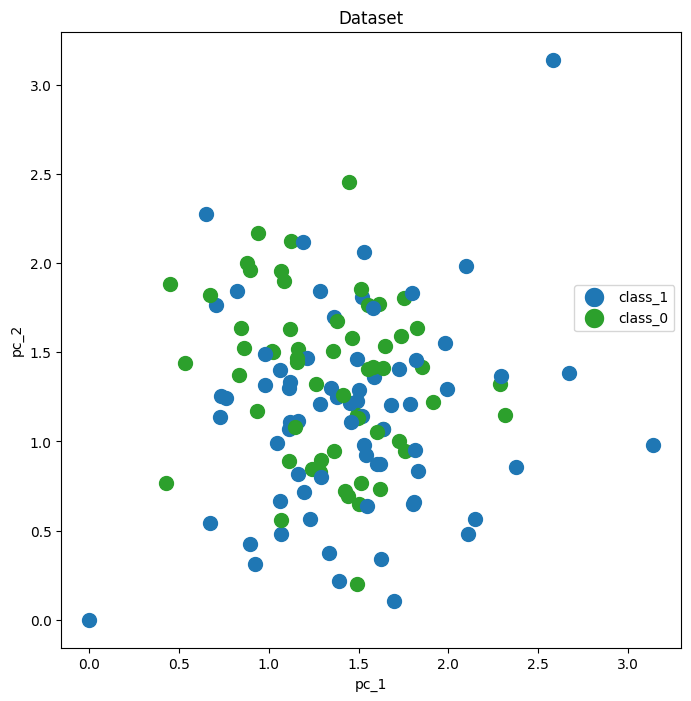

In [12]:
plot_sampled_features(X_pca[:, [2,3]], y, axis_x_name='pc_1', axis_y_name='pc_2', class_name_minus="class_0", class_name_plus="class_1")

# QWNN

Rodando uma única vez

In [22]:
class_a = 0
class_b = 1
# Loading some example data
wine = datasets.load_wine()
X_all = wine.data[:, :]
Y_all = wine.target
X, y = get_binary_dataset(X_all, Y_all, class_a, class_b)


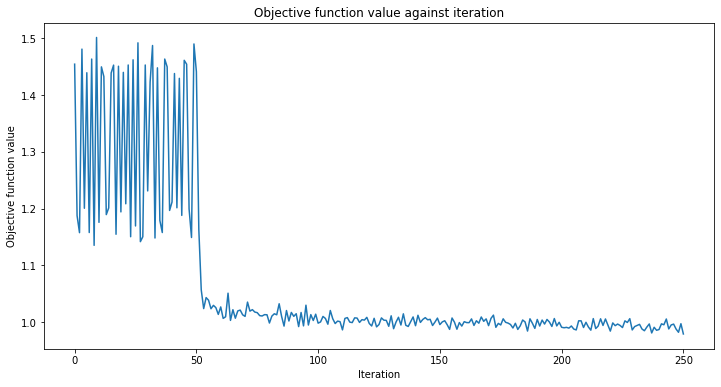

0.5384615384615384

In [23]:
qnn = get_opflow_qnn(qwnn_qc, feature_map, ansatz_qwnn, hamiltonian_qwnn)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=algorithm_globals.random_seed, stratify=y)
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
normalization = 2*np.pi
minmax_scale = MinMaxScaler((0, normalization)).fit(X_train_pca)
X_train_pca = minmax_scale.transform(X_train_pca)
X_test_pca = minmax_scale.transform(X_test_pca)
opflow_classifier = NeuralNetworkClassifier(qnn, optimizer = SPSA(), callback=callback_graph)
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
opflow_classifier.fit(X_train_pca, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
opflow_classifier.score(X_test_pca, y_test)

### Rodando várias vezes

Classes 1 e 2

In [12]:
class_a = 0
class_b = 1
# Loading some example data
wine = datasets.load_wine()
X_all = wine.data[:, :]
Y_all = wine.target
X, y = get_binary_dataset(X_all, Y_all, class_a, class_b)
score_list = run_experiments(X, y, n_times=2, ansatz_chosen="QWNN", apply_pca=True, pca_components=4)

iteracao : 0
score:  0.8846153846153846
iteracao : 1
score:  0.9230769230769231
Mean:  0.9038461538461539
Std:  0.019230769230769273
[0.8846153846153846, 0.9230769230769231]


In [9]:
print(score_list)

[0.9230769230769231, 0.9615384615384616, 0.9615384615384616, 0.8076923076923077, 0.8846153846153846]


Classes 1 e 3

In [18]:
class_a = 0
class_b = 2
# Loading some example data
wine = datasets.load_wine()
X_all = wine.data[:, :]
Y_all = wine.target
X, y = get_binary_dataset(X_all, Y_all, class_a, class_b)
score_list = run_experiments(X, y, n_times=5, ansatz_chosen="QWNN", apply_pca=True, pca_components=4)

iteracao : 0
score:  0.7727272727272727
iteracao : 1
score:  0.6818181818181818
iteracao : 2
score:  0.8636363636363636
iteracao : 3
score:  0.8636363636363636
iteracao : 4
score:  0.7727272727272727
Mean:  0.790909090909091
Std:  0.06803013430498077
[0.7727272727272727, 0.6818181818181818, 0.8636363636363636, 0.8636363636363636, 0.7727272727272727]


iteracao : 0
score:  0.7727272727272727
iteracao : 1
score:  0.6818181818181818
iteracao : 2
score:  0.8181818181818182
iteracao : 3
score:  1.0
iteracao : 4
score:  0.9090909090909091
Mean:  0.8363636363636363
Std:  0.1098458724872234
1.0
[0.7727272727272727, 0.6818181818181818, 0.8181818181818182, 1.0, 0.9090909090909091]


Classes 2 e 3

In [10]:
class_a = 1
class_b = 2
# Loading some example data
wine = datasets.load_wine()
X_all = wine.data[:, :]
Y_all = wine.target
X, y = get_binary_dataset(X_all, Y_all, class_a, class_b)
score_list = run_experiments(X, y, n_times=5, ansatz_chosen="QWNN", apply_pca=True)

iteracao : 0
score:  0.9166666666666666
iteracao : 1
score:  0.75
iteracao : 2
score:  0.875
iteracao : 3
score:  0.7916666666666666
iteracao : 4
score:  0.8333333333333334
Mean:  0.8333333333333333
Std:  0.05892556509887895
[0.9166666666666666, 0.75, 0.875, 0.7916666666666666, 0.8333333333333334]


iteracao : 0
score:  0.875
iteracao : 1
score:  0.8333333333333334
iteracao : 2
score:  0.7083333333333334
iteracao : 3
score:  0.875
iteracao : 4
score:  0.8333333333333334
Mean:  0.825
Std:  0.06123724356957944
0.875
[0.875, 0.8333333333333334, 0.7083333333333334, 0.875, 0.8333333333333334]


# Usando TTN

In [14]:
class_a = 0
class_b = 1
# Loading some example data
wine = datasets.load_wine()
X_all = wine.data[:, :]
Y_all = wine.target
X, y = get_binary_dataset(X_all, Y_all, class_a, class_b)

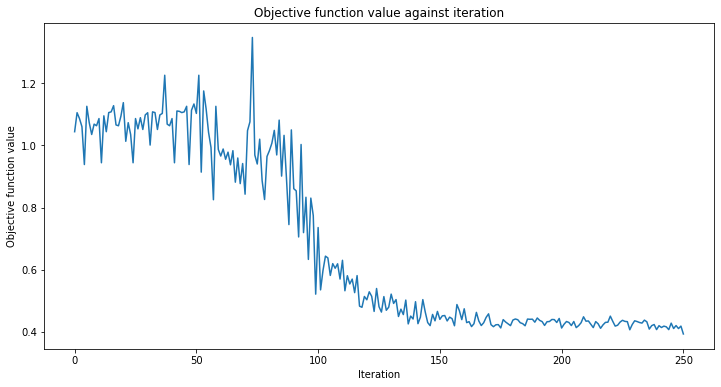

0.9230769230769231

In [15]:
qnn = get_opflow_qnn(ttn_qc, feature_map, ansatz_ttn, hamiltonian_ttn)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=algorithm_globals.random_seed, stratify=y)
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
normalization = np.pi
minmax_scale = MinMaxScaler((0, normalization)).fit(X_train_pca)
X_train_pca = minmax_scale.transform(X_train_pca)
X_test_pca = minmax_scale.transform(X_test_pca)
opflow_classifier = NeuralNetworkClassifier(qnn, optimizer = SPSA(), callback=callback_graph)
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
opflow_classifier.fit(X_train_pca, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
opflow_classifier.score(X_test_pca, y_test)

## Rodando Várias vezes

Classes 1 e 2

In [17]:
class_a = 0
class_b = 1
# Loading some example data
wine = datasets.load_wine()
X_all = wine.data[:, :]
Y_all = wine.target
X, y = get_binary_dataset(X_all, Y_all, class_a, class_b)
score_list = run_experiments(X, y, n_times=3, ansatz_chosen="TTN", apply_pca=True)

iteracao : 0
score:  0.8846153846153846
iteracao : 1
score:  0.9615384615384616
iteracao : 2
score:  0.9615384615384616
Mean:  0.935897435897436
Std:  0.036261886214694776
[0.8846153846153846, 0.9615384615384616, 0.9615384615384616]


Classes 1 e 3

In [19]:
class_a = 0
class_b = 2
# Loading some example data
wine = datasets.load_wine()
X_all = wine.data[:, :]
Y_all = wine.target
X, y = get_binary_dataset(X_all, Y_all, class_a, class_b)
score_list = run_experiments(X, y, n_times=5, ansatz_chosen="TTN", apply_pca=True)

iteracao : 0
score:  0.9545454545454546
iteracao : 1
score:  0.8181818181818182
iteracao : 2
score:  0.8636363636363636
iteracao : 3
score:  0.6363636363636364
iteracao : 4
score:  0.8636363636363636
Mean:  0.8272727272727274
Std:  0.1052348809344566
[0.9545454545454546, 0.8181818181818182, 0.8636363636363636, 0.6363636363636364, 0.8636363636363636]


In [21]:
class_a = 0
class_b = 2
# Loading some example data
wine = datasets.load_wine()
X_all = wine.data[:, :]
Y_all = wine.target
X, y = get_binary_dataset(X_all, Y_all, class_a, class_b)
score_list = run_experiments(X, y, n_times=5, ansatz_chosen="TTN", apply_pca=True)

iteracao : 0
score:  0.9545454545454546
iteracao : 1
score:  0.8181818181818182
iteracao : 2
score:  0.9545454545454546
iteracao : 3
score:  0.9545454545454546
iteracao : 4
score:  0.9090909090909091
Mean:  0.9181818181818182
Std:  0.05300865358950273
[0.9545454545454546, 0.8181818181818182, 0.9545454545454546, 0.9545454545454546, 0.9090909090909091]


Classes 2 e 3

In [20]:
class_a = 1
class_b = 2
# Loading some example data
wine = datasets.load_wine()
X_all = wine.data[:, :]
Y_all = wine.target
X, y = get_binary_dataset(X_all, Y_all, class_a, class_b)
score_list = run_experiments(X, y, n_times=5, ansatz_chosen="TTN", apply_pca=True)

iteracao : 0
score:  0.9166666666666666
iteracao : 1
score:  0.75
iteracao : 2
score:  0.875
iteracao : 3
score:  0.9583333333333334
iteracao : 4
score:  0.8333333333333334
Mean:  0.8666666666666666
Std:  0.07168604389202189
[0.9166666666666666, 0.75, 0.875, 0.9583333333333334, 0.8333333333333334]


iteracao : 0
score:  0.9166666666666666
iteracao : 1
score:  0.875
iteracao : 2
score:  0.75
iteracao : 3
score:  0.9583333333333334
iteracao : 4
score:  0.875
Mean:  0.875
Std:  0.06972166887783963
0.9583333333333334
[0.9166666666666666, 0.875, 0.75, 0.9583333333333334, 0.875]
